<a href="https://colab.research.google.com/github/vjacobsen/Inventory_Simulation/blob/main/Inventory_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inventory Simulation

In [ ]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import norm
from scipy import stats

## Optional: Enable data table display
%load_ext google.colab.data_table

$ EOQ = \sqrt{2 *\dfrac{Annual \ Demand * Cost \ per \ Order}{Annual \ Holding \ Cost \ per \ Unit}} $


* Annual holding cost is set at 15% of the bottle's cost
* The bottle cost is 60% of the retail value  



## Functions

In [ ]:
def run_simulation(demand_input):  

  global stock,inventory_data,safety_stock,lt_demand_variability,mean_lt_demand,\
          demand,reorder_point,open_orders,lost_sales,on_order_qty,period,closed_orders,\
          delivery_this_period
  
  # Inventory replenishment parameters -----------------------------------------
  lt_demand_variability,mean_lt_demand = lt_stdev_func(1000)  
  safety_stock = round(stats.norm.ppf(desired_service_level) * lt_demand_variability,0)
  reorder_point = round(mean_lt_demand + safety_stock,0) 

  lost_sales = 0
  open_orders = {}
  closed_orders = {}
  next_order_id = 0
  on_order_qty = 0
  inventory_data = []

  # Start inventory as function of demand, times a multiple
  initial_inventory = reorder_point + actual_order_qty/2
  stock = initial_inventory
  stockouts = 0
  percent_of_period_elapsed = 1

  # Simulate -------------------------------------------------------------------
  for period in np.arange(1,periods+1):
    
    stock_start = stock
    demand = round(demand_input[period-1]) 
      
    ## Subtract sold units from inventory - demand before order arrives---------
    if stock == 0: # Currently out of stock awaiting replenishment
      lost_sales = demand
      stock = 0
      stockouts = 0
      inventory_out_of_stock = 1
    
    elif demand > stock: # Stockout event
      lost_sales = abs(demand - stock)
      stock = 0
      stockouts = 1 # Period where stockout occured
      percent_filled = stock/demand 
      inventory_out_of_stock = 1
    
    else: # No stockout, inventory still positve
      stock = stock - demand
      lost_sales = 0
      stockouts = 0
      inventory_out_of_stock = 0

    ## Create replnishment order? ----------------------------------------------
    if stock + on_order_qty <= reorder_point: 
      order_count = 1
      oq = actual_order_qty
      order_lead_time = round(lead_time)
      delivery_period = period + order_lead_time
      
      order_details = {'delivery_period':delivery_period,
                        'order_qty':oq, 
                        'ordered_period':period,
                       'period_elapsed':percent_of_period_elapsed
                       }
                       
      on_order_qty = on_order_qty + oq # Update on-order qty
      open_orders[period] = order_details # Add order to dictionary

    else:
      order_count = 0

    ## Replenish stock - deliver order -----------------------------------------
    delete_orders = [] # Will be used later to pop orders from open order dict
    for order_id in open_orders: 
      if open_orders[order_id]['delivery_period'] == period:
        delivery_qty = open_orders[order_id]['order_qty']
        stock = stock + delivery_qty # Add order qty to stock
        closed_orders[order_id] = open_orders[order_id] # Move to closed orders
        on_order_qty = on_order_qty - delivery_qty
        delete_orders.append(order_id)
 
    for order_id in delete_orders: 
      open_orders.pop(order_id) # Remove delivered orders from open orders dict

    ## Metrics list
    inventory_data.append([period, 
                           demand, 
                           stock, 
                           on_order_qty, 
                           lost_sales,
                           order_count,
                           stockouts,
                           inventory_out_of_stock,
                           stock_start          
                           ]
                          ) 
  

  # Metrics data frame  
  inventory_data = pd.DataFrame(inventory_data,
                                columns=['period',
                                         'demand',
                                         'stock_on_hand',
                                         'stock_on_order',
                                         'lost_sales',
                                         'order_count',
                                         'stockouts',
                                         'inventory_out_of_stock',
                                         'stock_start'
                                         ]
                                ) 
  
# Calculate lead time demand variability - we'll bootstrap the demand
# Calculate standard deviation ofsum of demand sampled in groups of n periods, where n is the lead time duration 
def lt_stdev_func(samples):
  global stdev_list,lt_demand_list
  
  i=0
  lt_demand_list = []
  demand_list = list(demand_array)
  while i < samples:
    i = i+1
    sample_data = random.sample(demand_list,lead_time)
    lt_demand = sum(sample_data)
    lt_demand_list.append(lt_demand)
    
  return np.std(lt_demand_list),np.mean(lt_demand_list)


# Metrics calculation after simulation run is finished
def compute_metrics():
    global zero_on_hand_periods_pcnt, fulfilled_demand, total_demand, average_demand,\
            total_orders, cycles_without_stockout
    
    # Percentage of inventory cycles without a stockout event
    inventory_cycles = len(closed_orders) # this is essentially the number of cycles
    cycles_without_stockout = 1 - round(inventory_data['stockouts'].sum() / inventory_cycles,2)
     
    total_demand = round(inventory_data['demand'].sum())
    
    average_demand = round(inventory_data['demand'].mean())

calculate zero on hand periods based on number of periods in lead time!!!!

**Service level is the probability that the amount of inventory on hand during the lead time is sufficient to meet expected demand – that is, the probability that a stockout will not occur.**

## Input parameters

In [ ]:
# Input parameters
item_cost = 5
order_cost = 2
holding_cost = .05 # Percent of item cost

periods = 120 # number of periods to simulate
period_freq = 12 # number of periods in 1 year
lead_time = 2 # periods
desired_service_level = 0.85

# Generate random demand or provide list. UOM - Per period
mean_demand = 1000 
stdev_demand = 300 
demand_array = abs(np.random.normal(mean_demand,stdev_demand,periods))

# Calculated stock replenishment tresholds
annual_demand = mean_demand * period_freq
actual_order_qty = 12000 # override the economic order quantity
economic_order_qty = round(np.sqrt(2 * (order_cost*annual_demand) / (holding_cost*item_cost)),0)

## Run once

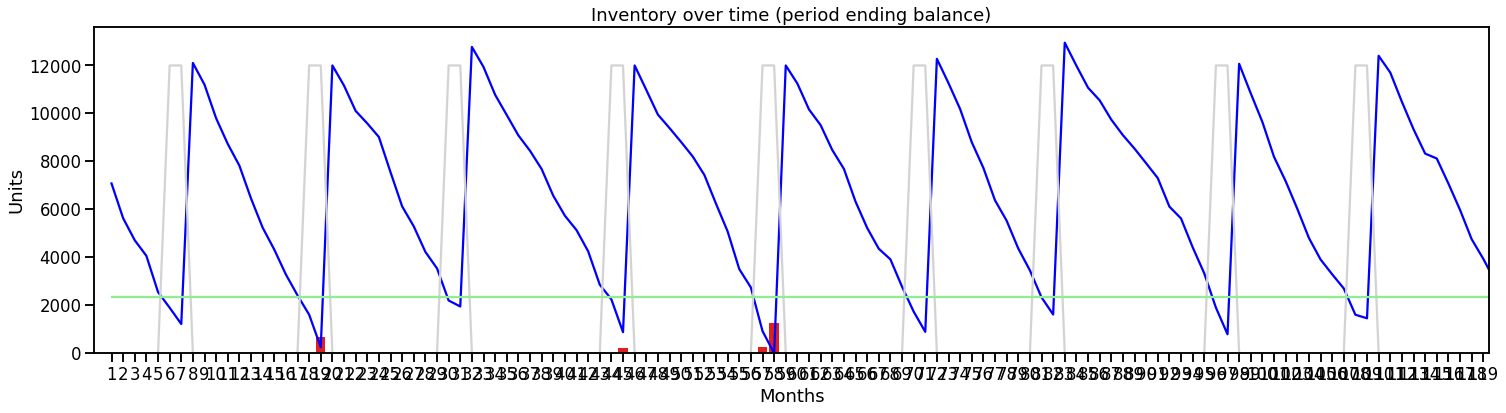


 Actual order qty 12000 
 safety stock 441.0 
 lead time demand  1924.6997143462797 
 reorder point  2366.0 
 desired service level 0.85 



Stockout envents -  3
Cycles without stockout -  67.0 %
_______________________________________________________________________ 

       period  demand  ...  inventory_out_of_stock  stock_start
count     120     120  ...                     120          120
mean       60     965  ...                       0         6655
std        34     303  ...                       0         3530
min         1     148  ...                       0            0
25%        30     747  ...                       0         3820
50%        60    1013  ...                       0         6512
75%        90    1164  ...                       0         9599
max       120    1816  ...                       1        12950

[8 rows x 9 columns]


In [ ]:
demand_array = abs(np.random.normal(mean_demand,stdev_demand,periods))

run_simulation(demand_array)
compute_metrics()

# Plot
df = inventory_data
sns.set_context('talk')
plt.figure(figsize=(25,6))
plt.title('Inventory over time (period ending balance)')
sns.lineplot(x=df['period'],y=df['stock_on_hand'],color='blue')
sns.lineplot(x=df['period'],y=df['stock_on_order'], color='lightgrey')
sns.lineplot(x=df['period'],y=reorder_point, color='lightgreen')
sns.barplot(x=df['period'],y=df['lost_sales'], color='red')
plt.ylabel('Units')
plt.xlabel('Months')
plt.xticks(np.arange(1, max(df['period']), period_freq/12))
plt.show()

# Print report
print('\n', 
      'Actual order qty', actual_order_qty, '\n',
      'safety stock', safety_stock, '\n',
      'lead time demand ', mean_lt_demand,'\n',
      'reorder point ', reorder_point ,'\n',
      'desired service level', desired_service_level, '\n'
      )
print('\n')

print( "Stockout envents - ", inventory_data['stockouts'].sum())
print("Cycles without stockout - ", 100*round(cycles_without_stockout,2),"%")

print("_______________________________________________________________________ \n")

print(inventory_data.describe().astype(int))

## Batch simulation

In [ ]:
simulation_number = 0
metrics = []
simulation_runs = 500

# Batch run
while simulation_number < simulation_runs:  
  demand_array = abs(np.random.normal(mean_demand,stdev_demand,periods))
  run_simulation(demand_array)
  compute_metrics()
  
  metrics.append([
                  total_demand,
                  average_demand,
                  cycles_without_stockout
                  ]
                 )
  
  simulation_number = simulation_number + 1

results = pd.DataFrame(metrics,columns=[
                              'mean_total_demand',
                              'mean_average_demand',
                              'cycles_without_stockout'])
results.mean().round(2)

mean_total_demand          119766.93
mean_average_demand           998.04
cycles_without_stockout         0.97
dtype: float64

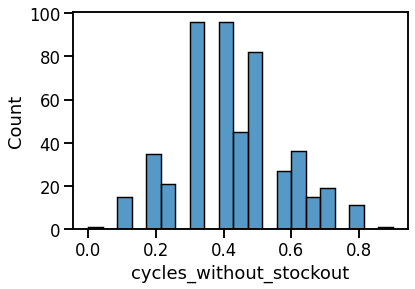

In [ ]:
sns.histplot(results['cycles_without_stockout'])

### Visualize Lead Time Demand distribution

For this simulation, it is normally distributed

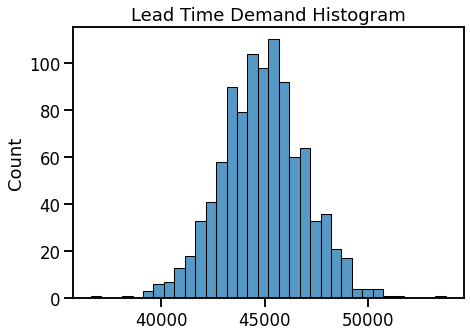

In [ ]:
plt.figure(figsize=(7,5))
plt.title('Lead Time Demand Histogram')
sns.set_context('talk')
sns.histplot(lt_demand_list)
plt.show()